# Chess Pix2Pix — Reproducible Training (A-only Zoom / Frame Removal)

This notebook is meant to be **shared and re-run from scratch**, while still supporting **resume** if Colab disconnects.

## Your data situation
- **A (rendered/synthetic)** images have an unwanted **frame/border**.
- **B (real)** images should be kept as-is.
- You updated A so they are now **388×388** (square) instead of 395×388.

✅ Therefore, we apply a **center crop (zoom-in) ONLY to A** to remove the frame, then resize both A and B to the training size.

## Dataset structure (must remain identical)
After unzip, the dataset must be located at:
```
/content/dataset/dataset_ready_for_colab/
  train/A  (inputs, rendered)
  train/B  (targets, real)
  val/A
  val/B
```

## Outputs (Drive)
Saved under:
```
/content/drive/MyDrive/chess_project/runs/<RUN_NAME>/
  checkpoints/
  samples/
  tests/
  logs/
```

## Resume (important)
The notebook saves `checkpoints/last.ckpt` every epoch (model + discriminator + optimizers + stage/epoch).  
So re-running the notebook will continue training from the last point (if RUN_NAME didnt changed).

In [ ]:
# ================================
# 0) CONFIG (edit here)
# ================================

# Dataset zip on Drive (paired A/B)
ZIP_PATH = "/content/drive/MyDrive/תכנות/chess_project (deep learning)/pairs_unzoomed_without_hands_fixedsize.zip"

# Where to extract inside Colab VM
EXTRACT_PATH = "/content/dataset"
DATASET_FOLDER_NAME = "pairs_unzoomed_without_hands_fixedsize"

# New images for inference (optional)
TEST_DIR = "/content/drive/MyDrive/chess_project/my_tests"

# Base output folder (nice + shareable)
RUNS_BASE_DIR = "/content/drive/MyDrive/chess_project/runs"

RUN_NAME = "pixed_sized_data(388x388)"

# ------------------------
# Image / preprocessing
# ------------------------
IMG_SIZE = 512   # train resolution (512 recommended)

# ✅ A-only zoom (frame removal)
# 1.0 disables. Examples: 0.98 (2% zoom), 0.95 (5% zoom), 0.91 (9% zoom).
A_CROP_FACTOR_TRAIN = 0.91
A_CROP_FACTOR_VAL   = A_CROP_FACTOR_TRAIN
B_CROP_FACTOR_TRAIN = 1.0   # keep real images as-is
B_CROP_FACTOR_VAL   = 1.0

# DataLoader
BATCH_SIZE = 1       # 512px is heavy; start with 1 on T4
NUM_WORKERS = 2

# ------------------------
# Training schedule
# ------------------------
# Stage 1: structure-first (strong pixel, tiny VGG)
STAGE1_EPOCHS = 200
LR_STAGE1 = 2e-4
LAMBDA_L1_STAGE1  = 100
LAMBDA_VGG_STAGE1 = 1
LAMBDA_GAN_STAGE1 = 1

# Stage 2: realism + sharp edges (reduce blur/halo)
STAGE2_EPOCHS = 120
LR_STAGE2 = 1e-4
LAMBDA_L1_STAGE2   = 10
LAMBDA_VGG_STAGE2  = 8
LAMBDA_GAN_STAGE2  = 8
LAMBDA_GRAD_STAGE2 = 10      # edge sharpening

REINIT_D_AT_STAGE2 = True

# Save / logging
SAVE_EVERY_EPOCHS = 10
SAVE_MILESTONE_EVERY = 50   # save every 50 epochs
SAVE_LAST_EVERY_EPOCH = True

# Inference: apply the SAME A-crop used in training (usually yes)
A_CROP_FACTOR_TEST = A_CROP_FACTOR_TRAIN

print("Config loaded. RUN_NAME =", RUN_NAME)
print(f"A-crop train={A_CROP_FACTOR_TRAIN}, val={A_CROP_FACTOR_VAL}, test={A_CROP_FACTOR_TEST} | B-crop train/val=1.0")

Config loaded. RUN_NAME = pixed_sized_data(388x388)
A-crop train=0.91, val=0.91, test=0.91 | B-crop train/val=1.0


In [ ]:
# ================================
# 1) DRIVE + GPU + SEED
# ================================

from google.colab import drive
import torch, random
import numpy as np
import os

drive.mount("/content/drive")

if torch.cuda.is_available():
    print(f"✅ GPU available: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ No GPU detected. Enable: Runtime -> Change runtime type -> GPU (T4 preferred).")

def set_seed(seed: int = 42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    print(f"Seed set to {seed}")

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Mounted at /content/drive
✅ GPU available: Tesla T4
Seed set to 42
Device: cuda


In [ ]:
# ================================
# 2) UNZIP DATASET (only if needed)
# ================================

import zipfile, os

os.makedirs(EXTRACT_PATH, exist_ok=True)
dataset_root = os.path.join(EXTRACT_PATH, DATASET_FOLDER_NAME)

if not os.path.exists(dataset_root):
    print("Unzipping dataset... (may take a minute)")
    with zipfile.ZipFile(ZIP_PATH, "r") as zf:
        zf.extractall(EXTRACT_PATH)
    print("✅ Extracted to:", dataset_root)
else:
    print("✅ Dataset already extracted:", dataset_root)

train_a_dir = os.path.join(dataset_root, "train", "A")
train_b_dir = os.path.join(dataset_root, "train", "B")
if not os.path.isdir(train_a_dir) or not os.path.isdir(train_b_dir):
    raise FileNotFoundError(f"Expected folders not found: {train_a_dir} and/or {train_b_dir}")

print("train/A count:", len(os.listdir(train_a_dir)))
print("train/B count:", len(os.listdir(train_b_dir)))

Unzipping dataset... (may take a minute)
✅ Extracted to: /content/dataset/pairs_unzoomed_without_hands_fixedsize
train/A count: 336
train/B count: 336


In [ ]:
# ================================
# 3) DATASET + DATALOADERS (paired A/B)
#    Key: crop ONLY A (frame removal), keep B unchanged
# ================================

from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
import random, os

def center_crop_factor(img: Image.Image, factor: float) -> Image.Image:
    factor = float(factor)
    if factor >= 1.0:
        return img
    w, h = img.size
    new_w, new_h = int(w * factor), int(h * factor)
    return TF.center_crop(img, (new_h, new_w))

def pad_to_square(img: Image.Image, fill=0) -> Image.Image:
    w, h = img.size
    if w == h:
        return img
    if w > h:
        pad_top = (w - h) // 2
        pad_bottom = (w - h) - pad_top
        padding = (0, pad_top, 0, pad_bottom)  # left, top, right, bottom
    else:
        pad_left = (h - w) // 2
        pad_right = (h - w) - pad_left
        padding = (pad_left, 0, pad_right, 0)
    return TF.pad(img, padding, fill=fill)

class PairedChessDataset(Dataset):
    def __init__(self, root: str, split: str = "train", augment: bool = True,
                 crop_factor_A: float = 1.0, crop_factor_B: float = 1.0):
        super().__init__()
        self.dir_A = os.path.join(root, split, "A")
        self.dir_B = os.path.join(root, split, "B")
        self.split = split
        self.augment = augment
        self.cropA = float(crop_factor_A)
        self.cropB = float(crop_factor_B)
        self.filenames = sorted(os.listdir(self.dir_A))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        name = self.filenames[idx]
        path_A = os.path.join(self.dir_A, name)
        path_B = os.path.join(self.dir_B, name)

        img_A = Image.open(path_A).convert("RGB")
        img_B = Image.open(path_B).convert("RGB")

        # ✅ A-only crop (frame removal)
        img_A = center_crop_factor(img_A, self.cropA)
        # ✅ B crop (usually 1.0)
        img_B = center_crop_factor(img_B, self.cropB)

        # Safety: ensure square before resize (A is 388x388 now, B is 480x480)
        img_A = pad_to_square(img_A, fill=0)
        img_B = pad_to_square(img_B, fill=0)

        # Augmentation: horizontal flip (safe for chess)
        if self.split == "train" and self.augment and random.random() > 0.5:
            img_A = TF.hflip(img_A)
            img_B = TF.hflip(img_B)

        # ✅ NEW: 180-degree rotation (view from the other side)
        if self.split == "train" and self.augment and random.random() > 0.5:
            img_A = TF.rotate(img_A, 180)
            img_B = TF.rotate(img_B, 180)

        # Resize to training resolution
        img_A = TF.resize(img_A, (IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.BICUBIC)
        img_B = TF.resize(img_B, (IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.BICUBIC)

        x = TF.to_tensor(img_A)
        y = TF.to_tensor(img_B)

        # Normalize to [-1, 1]
        x = (x - 0.5) * 2.0
        y = (y - 0.5) * 2.0

        return x, y, name

train_ds = PairedChessDataset(
    dataset_root, split="train", augment=True,
    crop_factor_A=A_CROP_FACTOR_TRAIN,
    crop_factor_B=B_CROP_FACTOR_TRAIN
)
val_ds   = PairedChessDataset(
    dataset_root, split="val", augment=False,
    crop_factor_A=A_CROP_FACTOR_VAL,
    crop_factor_B=B_CROP_FACTOR_VAL
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False, pin_memory=True)

print(f"✅ Data ready | train={len(train_ds)} | val={len(val_ds)} | batch={BATCH_SIZE} | IMG_SIZE={IMG_SIZE}")

✅ Data ready | train=336 | val=84 | batch=1 | IMG_SIZE=512


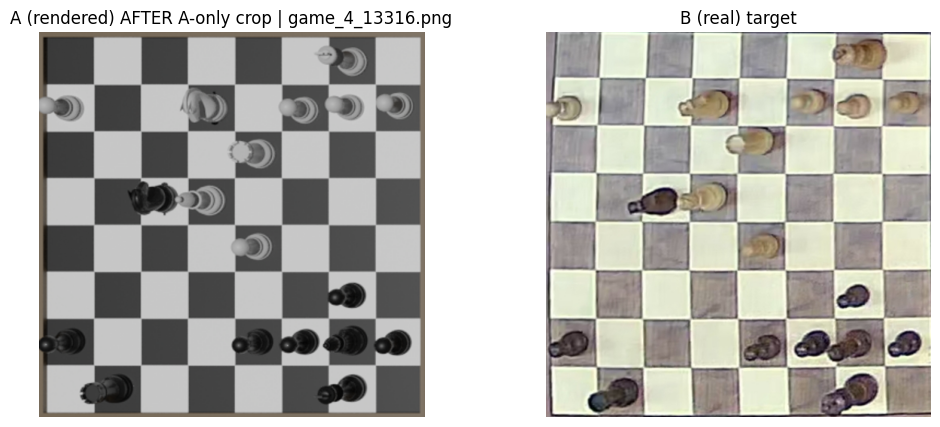

✅ If A and B align well (same board position / same piece locations), you're good.


In [ ]:
# ================================
# 4) PAIR PREVIEW (after A-only crop + resize)
#    Use this to verify that pairs still match visually.
# ================================

import matplotlib.pyplot as plt
import numpy as np
import torch

def denorm(t):
    return (t + 1) / 2.0

pairs_to_show = 3
x_batch, y_batch, names = next(iter(train_loader))

for i in range(min(pairs_to_show, x_batch.size(0))):
    x = denorm(x_batch[i]).permute(1,2,0).cpu().numpy()
    y = denorm(y_batch[i]).permute(1,2,0).cpu().numpy()

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.title(f"A (rendered) AFTER A-only crop | {names[i]}")
    plt.imshow(x); plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("B (real) target")
    plt.imshow(y); plt.axis("off")
    plt.show()

print("✅ If A and B align well (same board position / same piece locations), you're good.")

In [ ]:
# ================================
# 5) MODELS (U-Net Generator + PatchGAN Discriminator) + LOSSES
# ================================

import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
from torchvision.models import vgg19
import torch.nn.functional as F
import time
import torch

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super().__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(0.5))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super().__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(0.5))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        return torch.cat((x, skip_input), dim=1)

class GeneratorUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = nn.Conv2d(3, 64, 4, 2, 1)
        self.d2 = DownBlock(64, 128)
        self.d3 = DownBlock(128, 256)
        self.d4 = DownBlock(256, 512)
        self.d5 = DownBlock(512, 512)
        self.d6 = DownBlock(512, 512)
        self.d7 = DownBlock(512, 512)
        self.d8 = nn.Sequential(nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU(True))

        self.u1 = UpBlock(512, 512, dropout=True)
        self.u2 = UpBlock(1024, 512, dropout=True)
        self.u3 = UpBlock(1024, 512, dropout=True)
        self.u4 = UpBlock(1024, 512)
        self.u5 = UpBlock(1024, 256)
        self.u6 = UpBlock(512, 128)
        self.u7 = UpBlock(256, 64)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.d1(x); d2 = self.d2(d1); d3 = self.d3(d2); d4 = self.d4(d3)
        d5 = self.d5(d4); d6 = self.d6(d5); d7 = self.d7(d6); d8 = self.d8(d7)
        u1 = self.u1(d8, d7); u2 = self.u2(u1, d6); u3 = self.u3(u2, d5); u4 = self.u4(u3, d4)
        u5 = self.u5(u4, d3); u6 = self.u6(u5, d2); u7 = self.u7(u6, d1)
        return self.final(u7)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        def disc_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, 2, 1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *disc_block(6, 64, normalization=False),
            *disc_block(64, 128),
            *disc_block(128, 256),
            *disc_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        x = torch.cat((img_A, img_B), dim=1)
        return self.model(x)

# --- VGG perceptual loss with proper ImageNet normalization ---
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

def vgg_normalize(x):
    x = (x + 1) / 2.0
    return (x - IMAGENET_MEAN.to(x.device)) / IMAGENET_STD.to(x.device)

class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = vgg19(weights="DEFAULT").features
        self.slice = nn.Sequential()
        for i, layer in enumerate(list(vgg)[:35]):
            self.slice.add_module(str(i), layer)
        self.slice.eval()
        for p in self.slice.parameters():
            p.requires_grad = False

    def forward(self, fake, real):
        return F.l1_loss(self.slice(vgg_normalize(fake)), self.slice(vgg_normalize(real)))

# --- Gradient (edge) loss ---
class GradientLoss(nn.Module):
    def __init__(self):
        super().__init__()
        kx = torch.tensor([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=torch.float32).view(1,1,3,3)
        ky = torch.tensor([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=torch.float32).view(1,1,3,3)
        self.register_buffer("kx", kx)
        self.register_buffer("ky", ky)

    def forward(self, pred, target):
        pred01 = (pred + 1) / 2.0
        targ01 = (target + 1) / 2.0
        pred_g = pred01.mean(1, keepdim=True)
        targ_g = targ01.mean(1, keepdim=True)

        gx_p = F.conv2d(pred_g, self.kx, padding=1)
        gy_p = F.conv2d(pred_g, self.ky, padding=1)
        gx_t = F.conv2d(targ_g, self.kx, padding=1)
        gy_t = F.conv2d(targ_g, self.ky, padding=1)

        return F.l1_loss(gx_p, gx_t) + F.l1_loss(gy_p, gy_t)

print("✅ Models + losses defined.")

✅ Models + losses defined.


In [ ]:
# ================================
# 6) OUTPUT FOLDERS + CHECKPOINT UTILS
# ================================

import json

RUN_DIR = os.path.join(RUNS_BASE_DIR, RUN_NAME)
CKPT_DIR = os.path.join(RUN_DIR, "checkpoints")
SAMPLES_DIR = os.path.join(RUN_DIR, "samples")
TESTS_DIR = os.path.join(RUN_DIR, "tests")
LOGS_DIR = os.path.join(RUN_DIR, "logs")

for d in [RUN_DIR, CKPT_DIR, SAMPLES_DIR, TESTS_DIR, LOGS_DIR]:
    os.makedirs(d, exist_ok=True)

LAST_CKPT_PATH = os.path.join(CKPT_DIR, "last.ckpt")
BEST_GEN_PATH  = os.path.join(CKPT_DIR, "best_generator.pth")

print("Run directory:", RUN_DIR)
print("last.ckpt:", LAST_CKPT_PATH)
print("best gen:", BEST_GEN_PATH)

@torch.no_grad()
def save_val_triplet(generator, val_loader, out_path: str):
    generator.eval()
    x, y, name = next(iter(val_loader))
    x, y = x.to(device), y.to(device)
    y_hat = generator(x)
    triplet = torch.cat((x, y_hat, y), dim=3)  # input | fake | real
    save_image(triplet, out_path, normalize=True)

def save_checkpoint(path, stage_name, epoch, generator, discriminator, opt_g, opt_d, best_val_metric):
    ckpt = {
        "stage": stage_name,
        "epoch": epoch,
        "best_val_metric": best_val_metric,
        "generator": generator.state_dict(),
        "discriminator": discriminator.state_dict(),
        "opt_g": opt_g.state_dict(),
        "opt_d": opt_d.state_dict(),
        "img_size": IMG_SIZE,
        "batch_size": BATCH_SIZE,
        "crop_factors": {
            "A_train": A_CROP_FACTOR_TRAIN, "A_val": A_CROP_FACTOR_VAL, "A_test": A_CROP_FACTOR_TEST,
            "B_train": B_CROP_FACTOR_TRAIN, "B_val": B_CROP_FACTOR_VAL
        }
    }
    torch.save(ckpt, path)

def load_checkpoint(path, generator, discriminator, opt_g=None, opt_d=None, map_location=None):
    ckpt = torch.load(path, map_location=map_location)
    generator.load_state_dict(ckpt["generator"])
    discriminator.load_state_dict(ckpt["discriminator"])
    if opt_g is not None and "opt_g" in ckpt:
        opt_g.load_state_dict(ckpt["opt_g"])
    if opt_d is not None and "opt_d" in ckpt:
        opt_d.load_state_dict(ckpt["opt_d"])
    return ckpt

@torch.no_grad()
def compute_val_metric(generator, val_loader, max_batches=25):
    generator.eval()
    crit = nn.SmoothL1Loss(beta=0.02)
    total = 0.0
    n = 0
    for i, (x, y, name) in enumerate(val_loader):
        if i >= max_batches:
            break
        x, y = x.to(device), y.to(device)
        y_hat = generator(x)
        total += crit(y_hat, y).item()
        n += 1
    return total / max(n, 1)

print("✅ Checkpoint utilities ready.")

Run directory: /content/drive/MyDrive/chess_project/runs/pixed_sized_data(388x388)
last.ckpt: /content/drive/MyDrive/chess_project/runs/pixed_sized_data(388x388)/checkpoints/last.ckpt
best gen: /content/drive/MyDrive/chess_project/runs/pixed_sized_data(388x388)/checkpoints/best_generator.pth
✅ Checkpoint utilities ready.


In [ ]:
# ================================
# 6.1) LOGGING SETUP (CSV + META)
# ================================

import csv
from datetime import datetime
import platform

METRICS_CSV = os.path.join(LOGS_DIR, "metrics.csv")
RUN_META_JSON = os.path.join(LOGS_DIR, "run_meta.json")

# 1) Create metrics.csv header once
if not os.path.exists(METRICS_CSV):
    with open(METRICS_CSV, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow([
            "timestamp", "stage", "epoch",
            "loss_D", "loss_G",
            "loss_gan", "loss_pix", "loss_vgg", "loss_grad",
            "val_metric", "lr_g", "lr_d"
        ])

# 2) Save run metadata once (reproducibility for report)
if not os.path.exists(RUN_META_JSON):
    accelerator = (
        torch.cuda.get_device_name(0) if torch.cuda.is_available()
        else ("mps" if torch.backends.mps.is_available() else "cpu")
    )

    meta = {
        "run_name": RUN_NAME,
        "created_at": datetime.now().isoformat(),
        "system": platform.platform(),
        "device": str(device),
        "accelerator": accelerator,

        "img_size": IMG_SIZE,
        "batch_size": BATCH_SIZE,
        "zip_path": ZIP_PATH,
        "dataset_folder": DATASET_FOLDER_NAME,

        "crop_factors": {
            "A_train": A_CROP_FACTOR_TRAIN, "A_val": A_CROP_FACTOR_VAL, "A_test": A_CROP_FACTOR_TEST,
            "B_train": B_CROP_FACTOR_TRAIN, "B_val": B_CROP_FACTOR_VAL
        },

        "stage1": {
            "epochs": STAGE1_EPOCHS, "lr": LR_STAGE1,
            "lambda_gan": LAMBDA_GAN_STAGE1, "lambda_l1": LAMBDA_L1_STAGE1, "lambda_vgg": LAMBDA_VGG_STAGE1
        },
        "stage2": {
            "epochs": STAGE2_EPOCHS, "lr": LR_STAGE2,
            "lambda_gan": LAMBDA_GAN_STAGE2, "lambda_l1": LAMBDA_L1_STAGE2,
            "lambda_vgg": LAMBDA_VGG_STAGE2, "lambda_grad": LAMBDA_GRAD_STAGE2,
            "reinit_d": REINIT_D_AT_STAGE2
        },
    }

    with open(RUN_META_JSON, "w") as f:
        json.dump(meta, f, indent=2)

print("✅ Logging files ready:")
print(" -", METRICS_CSV)
print(" -", RUN_META_JSON)


✅ Logging files ready:
 - /content/drive/MyDrive/chess_project/runs/pixed_sized_data(388x388)/logs/metrics.csv
 - /content/drive/MyDrive/chess_project/runs/pixed_sized_data(388x388)/logs/run_meta.json


In [ ]:

# ================================
# 7) TRAINING (two-stage) + RESUME
# ================================

criterion_gan = nn.MSELoss()
criterion_pix_stage1 = nn.L1Loss()
criterion_pix_stage2 = nn.SmoothL1Loss(beta=0.02)
criterion_vgg = VGGLoss().to(device)
criterion_grad = GradientLoss().to(device)

BETAS = (0.5, 0.999)

def make_optimizers(generator, discriminator, lr):
    opt_g = optim.Adam(generator.parameters(), lr=lr, betas=BETAS)
    opt_d = optim.Adam(discriminator.parameters(), lr=lr, betas=BETAS)
    return opt_g, opt_d

def train_stage(stage_name, generator, discriminator, opt_g, opt_d, epochs,
                lambda_gan, lambda_l1, lambda_vgg, lambda_grad,
                start_epoch=0, best_val_metric=float("inf")):

    print(f"\n=== {stage_name} ===")
    print(f"epochs={epochs}, lr={opt_g.param_groups[0]['lr']}")
    print(f"lambdas: gan={lambda_gan}, l1={lambda_l1}, vgg={lambda_vgg}, grad={lambda_grad}")

    pix_criterion = criterion_pix_stage1 if stage_name == "STAGE1" else criterion_pix_stage2

    for epoch in range(start_epoch, epochs):
        generator.train()
        discriminator.train()

        # --- epoch accumulators for report-quality logging ---
        sum_loss_D = 0.0
        sum_loss_G = 0.0
        sum_gan = 0.0
        sum_pix = 0.0
        sum_vgg = 0.0
        sum_grad = 0.0
        n_batches = 0


        for x, y, name in train_loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

            # ---- Generator ----
            opt_g.zero_grad()
            y_hat = generator(x)
            pred_fake = discriminator(x, y_hat)

            valid = torch.ones_like(pred_fake)
            fake  = torch.zeros_like(pred_fake)

            loss_gan = criterion_gan(pred_fake, valid)
            loss_l1  = pix_criterion(y_hat, y)
            loss_vgg = criterion_vgg(y_hat, y) if lambda_vgg > 0 else torch.tensor(0.0, device=device)
            loss_grad = criterion_grad(y_hat, y) if lambda_grad > 0 else torch.tensor(0.0, device=device)

            loss_G = (lambda_gan * loss_gan) + (lambda_l1 * loss_l1) + (lambda_vgg * loss_vgg) + (lambda_grad * loss_grad)
            loss_G.backward()
            opt_g.step()

            # ---- Discriminator ----
            opt_d.zero_grad()
            pred_real = discriminator(x, y)
            loss_real = criterion_gan(pred_real, valid)

            pred_fake_det = discriminator(x, y_hat.detach())
            loss_fake = criterion_gan(pred_fake_det, fake)

            loss_D = 0.5 * (loss_real + loss_fake)
            loss_D.backward()
            opt_d.step()

            # --- accumulate for epoch averages ---
            sum_loss_D += loss_D.item()
            sum_loss_G += loss_G.item()
            sum_gan += loss_gan.item()
            sum_pix += loss_l1.item()
            sum_vgg += (loss_vgg.item() if lambda_vgg > 0 else 0.0)
            sum_grad += (loss_grad.item() if lambda_grad > 0 else 0.0)
            n_batches += 1


        # --- epoch averages (report-friendly) ---
        avg_loss_D = sum_loss_D / max(n_batches, 1)
        avg_loss_G = sum_loss_G / max(n_batches, 1)
        avg_gan = sum_gan / max(n_batches, 1)
        avg_pix = sum_pix / max(n_batches, 1)
        avg_vgg = sum_vgg / max(n_batches, 1)
        avg_grad = sum_grad / max(n_batches, 1)

        # Val metric for best model
        val_m = compute_val_metric(generator, val_loader, max_batches=25)

        # --- write one line to metrics.csv ---
        with open(METRICS_CSV, "a", newline="") as f:
            w = csv.writer(f)
            w.writerow([
                datetime.now().isoformat(), stage_name, epoch + 1,
                avg_loss_D, avg_loss_G,
                avg_gan, avg_pix, avg_vgg, avg_grad,
                val_m,
                opt_g.param_groups[0]["lr"], opt_d.param_groups[0]["lr"]
            ])

        print(f"[{stage_name}] epoch {epoch+1}/{epochs} | D={avg_loss_D:.4f} | G={avg_loss_G:.4f} | val_metric={val_m:.4f}")


        # Save sample image occasionally
        if (epoch + 1) % SAVE_EVERY_EPOCHS == 0 or (epoch + 1) == epochs:
            sample_path = os.path.join(SAMPLES_DIR, f"{stage_name}_epoch_{epoch+1:04d}.png")
            save_val_triplet(generator, val_loader, sample_path)
            print("  saved sample:", sample_path)

        # Best model saving (based on val metric)
        if val_m < best_val_metric:
            best_val_metric = val_m
            torch.save(generator.state_dict(), BEST_GEN_PATH)
            print("  ✅ new BEST generator saved:", BEST_GEN_PATH)

            best_sample_path = os.path.join(SAMPLES_DIR, f"{stage_name}_BEST_epoch_{epoch+1:04d}.png")
            save_val_triplet(generator, val_loader, best_sample_path)
            print("  🏆 saved BEST sample:", best_sample_path)

        # Milestone saving (e.g. every 50 epochs)
        if (epoch + 1) % SAVE_MILESTONE_EVERY == 0:
            # generator-only (easy for local inference)
            gen_only_path = os.path.join(CKPT_DIR, f"{stage_name}_gen_epoch_{epoch+1:04d}.pth")
            torch.save(generator.state_dict(), gen_only_path)
            print("  💾 saved milestone generator:", gen_only_path)

            # full checkpoint (resume exactly from this epoch)
            full_path = os.path.join(CKPT_DIR, f"{stage_name}_full_epoch_{epoch+1:04d}.ckpt")
            save_checkpoint(full_path, stage_name, epoch, generator, discriminator, opt_g, opt_d, best_val_metric)
            print("  💾 saved milestone full ckpt:", full_path)

        # Always update last.ckpt at the end of the epoch (for resume)
        if SAVE_LAST_EVERY_EPOCH:
            save_checkpoint(LAST_CKPT_PATH, stage_name, epoch, generator, discriminator, opt_g, opt_d, best_val_metric)

    return best_val_metric


# ---------------------------
# Init or Resume
# ---------------------------
generator = GeneratorUNet().to(device)
discriminator = Discriminator().to(device)
opt_g, opt_d = make_optimizers(generator, discriminator, lr=LR_STAGE1)

start_stage = "STAGE1"
start_epoch = 0
best_val_metric = float("inf")

if os.path.exists(LAST_CKPT_PATH):
    print("Found checkpoint:", LAST_CKPT_PATH)
    ckpt = load_checkpoint(LAST_CKPT_PATH, generator, discriminator, opt_g, opt_d, map_location=device)
    start_stage = ckpt.get("stage", "STAGE1")
    start_epoch = int(ckpt.get("epoch", 0)) + 1
    best_val_metric = float(ckpt.get("best_val_metric", float("inf")))
    print(f"Resume from stage={start_stage}, epoch={start_epoch}, best_val_metric={best_val_metric:.4f}")
else:
    print("No checkpoint found. Starting fresh.")

if start_stage == "STAGE1":
    best_val_metric = train_stage(
        stage_name="STAGE1",
        generator=generator,
        discriminator=discriminator,
        opt_g=opt_g,
        opt_d=opt_d,
        epochs=STAGE1_EPOCHS,
        lambda_gan=LAMBDA_GAN_STAGE1,
        lambda_l1=LAMBDA_L1_STAGE1,
        lambda_vgg=LAMBDA_VGG_STAGE1,
        lambda_grad=0,
        start_epoch=start_epoch,
        best_val_metric=best_val_metric,
    )
    start_stage = "STAGE2"
    start_epoch = 0

if start_stage == "STAGE2":
    if REINIT_D_AT_STAGE2:
        discriminator = Discriminator().to(device)

    opt_g, opt_d = make_optimizers(generator, discriminator, lr=LR_STAGE2)

    if os.path.exists(LAST_CKPT_PATH):
        ckpt_tmp = torch.load(LAST_CKPT_PATH, map_location=device)
        if ckpt_tmp.get("stage") == "STAGE2":
            load_checkpoint(LAST_CKPT_PATH, generator, discriminator, opt_g, opt_d, map_location=device)
            start_epoch = int(ckpt_tmp.get("epoch", 0)) + 1
            best_val_metric = float(ckpt_tmp.get("best_val_metric", best_val_metric))
            print(f"Resume STAGE2 from epoch={start_epoch}, best_val_metric={best_val_metric:.4f}")
        else:
            start_epoch = 0

    best_val_metric = train_stage(
        stage_name="STAGE2",
        generator=generator,
        discriminator=discriminator,
        opt_g=opt_g,
        opt_d=opt_d,
        epochs=STAGE2_EPOCHS,
        lambda_gan=LAMBDA_GAN_STAGE2,
        lambda_l1=LAMBDA_L1_STAGE2,
        lambda_vgg=LAMBDA_VGG_STAGE2,
        lambda_grad=LAMBDA_GRAD_STAGE2,
        start_epoch=start_epoch,
        best_val_metric=best_val_metric,
    )

print("\n✅ Training complete.")
print("Best generator:", BEST_GEN_PATH)
print("Last checkpoint:", LAST_CKPT_PATH)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:07<00:00, 77.2MB/s]


No checkpoint found. Starting fresh.

=== STAGE1 ===
epochs=200, lr=0.0002
lambdas: gan=1, l1=100, vgg=1, grad=0
[STAGE1] epoch 1/200 | D=0.1464 | G=25.1796 | val_metric=0.2078
  ✅ new BEST generator saved: /content/drive/MyDrive/chess_project/runs/pixed_sized_data(388x388)_for_csv/checkpoints/best_generator.pth
  🏆 saved BEST sample: /content/drive/MyDrive/chess_project/runs/pixed_sized_data(388x388)_for_csv/samples/STAGE1_BEST_epoch_0001.png
[STAGE1] epoch 2/200 | D=0.1075 | G=20.9915 | val_metric=0.1544
  ✅ new BEST generator saved: /content/drive/MyDrive/chess_project/runs/pixed_sized_data(388x388)_for_csv/checkpoints/best_generator.pth
  🏆 saved BEST sample: /content/drive/MyDrive/chess_project/runs/pixed_sized_data(388x388)_for_csv/samples/STAGE1_BEST_epoch_0002.png
[STAGE1] epoch 3/200 | D=0.0953 | G=18.9386 | val_metric=0.1432
  ✅ new BEST generator saved: /content/drive/MyDrive/chess_project/runs/pixed_sized_data(388x388)_for_csv/checkpoints/best_generator.pth
  🏆 saved BEST s

KeyboardInterrupt: 

Loading BEST generator: /content/drive/MyDrive/chess_project/runs/pixed_sized_data(388x388)/checkpoints/best_generator.pth
Found 6 test images.
✅ Inference done. Saved to: /content/drive/MyDrive/chess_project/runs/pixed_sized_data(388x388)/tests


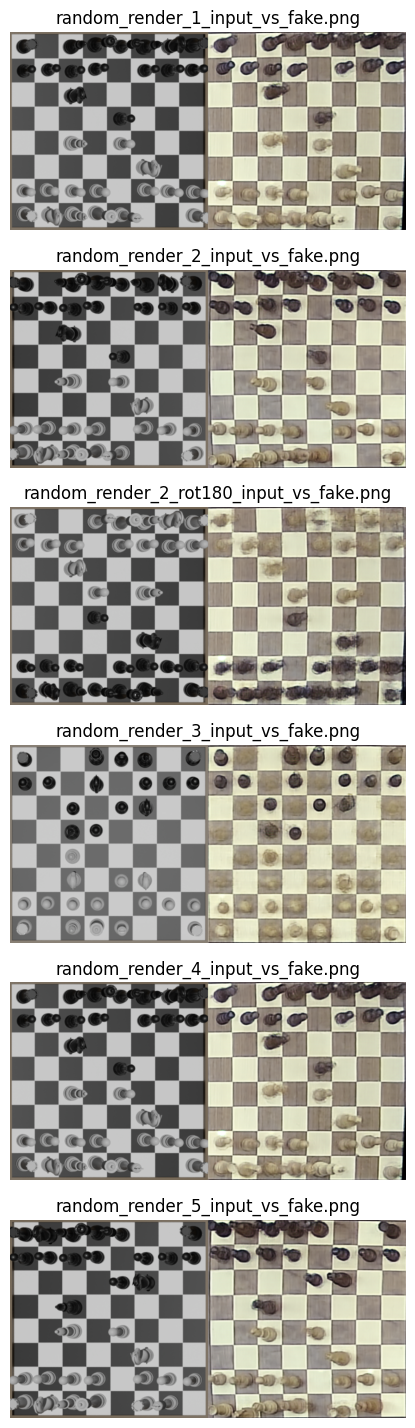

In [ ]:
# ================================
# 8) INFERENCE ON NEW RENDERED IMAGES (A-style)
# ================================

import glob
import matplotlib.pyplot as plt

gen = GeneratorUNet().to(device)

if os.path.exists(BEST_GEN_PATH):
    print("Loading BEST generator:", BEST_GEN_PATH)
    gen.load_state_dict(torch.load(BEST_GEN_PATH, map_location=device))
elif os.path.exists(LAST_CKPT_PATH):
    print("Loading generator from last.ckpt:", LAST_CKPT_PATH)
    tmp_disc = Discriminator().to(device)
    tmp_opt_g, tmp_opt_d = make_optimizers(gen, tmp_disc, lr=LR_STAGE2)
    load_checkpoint(LAST_CKPT_PATH, gen, tmp_disc, tmp_opt_g, tmp_opt_d, map_location=device)
else:
    raise FileNotFoundError("No trained model found. Train first.")

gen.eval()

exts = ("*.png", "*.jpg", "*.jpeg", "*.webp", "*.bmp")
test_files = []
for e in exts:
    test_files += glob.glob(os.path.join(TEST_DIR, e))
test_files = sorted(test_files)

if not test_files:
    raise FileNotFoundError(f"No images found in TEST_DIR: {TEST_DIR}")

print(f"Found {len(test_files)} test images.")

def preprocess_test_A(img_pil: Image.Image) -> torch.Tensor:
    img = img_pil.convert("RGB")
    img = center_crop_factor(img, A_CROP_FACTOR_TEST)
    img = pad_to_square(img, fill=0)
    img = TF.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.BICUBIC)

    x = TF.to_tensor(img)
    x = (x - 0.5) * 2.0
    return x.unsqueeze(0)

@torch.no_grad()
def run_one(path: str):
    img = Image.open(path)
    x = preprocess_test_A(img).to(device)
    y_hat = gen(x)
    return x.cpu(), y_hat.cpu()

os.makedirs(TESTS_DIR, exist_ok=True)

saved = []
for fp in test_files:
    x, y_hat = run_one(fp)
    base = os.path.splitext(os.path.basename(fp))[0]
    out_fake = os.path.join(TESTS_DIR, f"{base}_fake.png")
    out_grid = os.path.join(TESTS_DIR, f"{base}_input_vs_fake.png")

    save_image(y_hat, out_fake, normalize=True)
    grid = torch.cat([x, y_hat], dim=3)
    save_image(grid, out_grid, normalize=True)
    saved.append(out_grid)

print("✅ Inference done. Saved to:", TESTS_DIR)

show_n = min(6, len(saved))
plt.figure(figsize=(14, 3 * show_n))
for i in range(show_n):
    img = Image.open(saved[i])
    plt.subplot(show_n, 1, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(os.path.basename(saved[i]))
plt.show()

In [ ]:
# ================================
# 9) RUN SUMMARY (for report / docs)
# ================================

import json, datetime

summary = {
    "timestamp": datetime.datetime.now().isoformat(),
    "run_name": RUN_NAME,
    "run_dir": RUN_DIR,
    "dataset": {
        "zip_path": ZIP_PATH,
        "extract_path": EXTRACT_PATH,
        "dataset_root": dataset_root,
        "counts": {"train_pairs": len(train_ds), "val_pairs": len(val_ds)},
    },
    "hardware": {
        "device": str(device),
        "cuda_available": torch.cuda.is_available(),
        "gpu_name": torch.cuda.get_device_name(0) if torch.cuda.is_available() else None,
    },
    "preprocessing": {
        "img_size": IMG_SIZE,
        "batch_size": BATCH_SIZE,
        "A_only_crop": {"train": A_CROP_FACTOR_TRAIN, "val": A_CROP_FACTOR_VAL, "test": A_CROP_FACTOR_TEST},
        "B_crop": {"train": B_CROP_FACTOR_TRAIN, "val": B_CROP_FACTOR_VAL},
        "resize_interpolation": "bicubic",
        "normalization": "to [-1,1] via (x-0.5)*2; generator output Tanh",
        "augmentation": "random horizontal flip in training",
    },
    "training_schedule": {
        "stage1": {"epochs": STAGE1_EPOCHS, "lr": LR_STAGE1, "lambda_l1": LAMBDA_L1_STAGE1, "lambda_vgg": LAMBDA_VGG_STAGE1, "lambda_gan": LAMBDA_GAN_STAGE1},
        "stage2": {"epochs": STAGE2_EPOCHS, "lr": LR_STAGE2, "lambda_l1": LAMBDA_L1_STAGE2, "lambda_vgg": LAMBDA_VGG_STAGE2, "lambda_gan": LAMBDA_GAN_STAGE2, "lambda_grad": LAMBDA_GRAD_STAGE2, "reinit_discriminator": REINIT_D_AT_STAGE2, "pixel_loss_stage2": "SmoothL1(beta=0.02)"},
        "save_every_epochs": SAVE_EVERY_EPOCHS,
    },
    "outputs": {"checkpoints_dir": CKPT_DIR, "samples_dir": SAMPLES_DIR, "tests_dir": TESTS_DIR, "logs_dir": LOGS_DIR, "last_ckpt": LAST_CKPT_PATH, "best_generator": BEST_GEN_PATH},
}

print("===== RUN SUMMARY =====")
print(json.dumps(summary, indent=2, ensure_ascii=False))

os.makedirs(LOGS_DIR, exist_ok=True)
summary_path = os.path.join(LOGS_DIR, "run_summary.json")
with open(summary_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print("\n✅ Saved summary to:", summary_path)
print("\nResume tip: set NEW_RUN=False to continue the same run (same RUN_NAME).")

NameError: name 'RUN_NAME' is not defined